# Offline Exercise

This notebook has the questions and instructions for the offline exercise. If you haven't already, please go through the `README.md` file before you begin answering the questions here.

Make sure you do NOT commit your answers back to the repo. Instead, copy-paste this notebook together with the `touches.sqlite3` file to a separate folder in your machine, type your answers in that copied notebook, and when you're done, share the new Jupyter notebook back with the recruiter together with additional modules, graphs etc. that you may have. You would need to use the data in the `touches.sqlite3` file to answer all the questions.

### Question 1. Find the most common industry out of all the companies that were contacted.

In [75]:
#Set the local directory and import the library(s)
%cd c:\\Users\chelt\Desktop\Salesloft Assessment
import sqlite3 as s3
import pandas as pd
import matplotlib.pyplot as plt

#connect to the db
conn = s3.connect("touches.sqlite3")
c = conn.cursor()

#check out some of the data
for row in c.execute('SELECT * FROM companies LIMIT 5;'): print (row)

c:\Users\chelt\Desktop\Salesloft Assessment
(1, 'Diversified Telecommunication Services', '51-200 employees', 'US/Eastern')
(2, 'Internet Software & Services', '51-200 employees', 'US/Mountain')
(4, 'Internet Software & Services', '', 'US/Pacific')
(6, 'Diversified Financial Services', '11-50 employees', 'US/Pacific')
(8, 'Telecommunications', '', 'US/Eastern')


In [76]:
#write the SQL query

df1 = pd.read_sql_query('''
        SELECT   c.industry 
                ,count(distinct t.id) as 'touches'
        FROM touches as t 
        LEFT JOIN persons as p
        ON t.person_id = p.id
        LEFT JOIN companies as c
        on p.company_id = c.id
        WHERE t.status = 'completed'
        GROUP BY c.industry
        ORDER BY count(distinct t.id) DESC
        LIMIT 1
        ''',conn)
print(df1.head())

                       industry  touches
0  Internet Software & Services   248155


In [ ]:
#Internet Software and Services is the most contacted industry with 248,155 touches

#I am not 100% sure of the touch status but intuitively I feel a touch must be completed for it to exist as a data point

### Question 2. What is the most common touch type sellers use when they’re making their first touch with a person? What about first touch with a company?

##### **FIRST THINGS FIRST... the touch_scheduled_on column is available as date and not date/time. Date/Time would be ideal since it is precise, so I question the validity of the analysis, given that a rep might have contact with a company or persons multiple times on the first day, so we cannot be precise in finding the first contact date via the MIN function

In [77]:
#check out some of the data
for row in c.execute('SELECT typeof(touch_scheduled_on) FROM touches LIMIT 1;'): print (row)

('text',)


##### **Uh oh, date/time is being read as text.  I will have to account for this.

In [51]:
#To find the first touch we will have to inner join a sub query with the MIN touch_scheduled_on Date and status = completed

#write the SQL query for most common COMPLETED touch type on first touch with a person

df2 = pd.read_sql_query('''
        SELECT   x.touch_type
                ,count(distinct x.id) as 'touches'
        FROM
        (
        SELECT   t.touch_type 
                ,t.id
                ,date(t.touch_scheduled_on) 
        FROM touches as t 
        LEFT JOIN persons as p
        ON t.person_id = p.id
        LEFT JOIN companies as c
        on p.company_id = c.id
        INNER JOIN 
        (
        SELECT
         p.id as 'person_id'
        ,MIN(date(t.touch_scheduled_on)) as 'FirstTouch'
        FROM touches as t 
        INNER JOIN persons as p
        ON t.person_id = p.id
        WHERE t.status = 'completed'
        GROUP BY p.id
        ) as J
        on J.person_id = t.person_id AND J.FirstTouch = t.touch_scheduled_on
        ) as x
        GROUP BY x.touch_type
        ORDER BY count(distinct x.id) desc 
        ''', conn)

print(df2.head())

    touch_type  touches
0        Other    46229
1        Email    27209
2        Phone    23927
3  Integration     1228


#### **It looks like 'Other' is the primary means of contact for the first touch with a person having 46,299 records of all first touches.  This seems odd but I checked the output on a platform I am very proficient in and the results match?

In [57]:
#write the SQL query for most common COMPLETED touch type on first touch with a company

df3 = pd.read_sql_query('''
        SELECT  
                 x.touch_type
                ,count(distinct x.id) as 'touches'
        FROM
        (
        SELECT   t.touch_type 
                ,t.id
                ,date(t.touch_scheduled_on) 
        FROM touches as t 
        LEFT JOIN persons as p
        ON t.person_id = p.id
        LEFT JOIN companies as c
        on p.company_id = c.id
        INNER JOIN 
        (
        SELECT
         c.id as 'company_id'
        ,MIN(date(t.touch_scheduled_on)) as 'FirstTouch'
        FROM touches as t 
        INNER JOIN persons as p
        ON t.person_id = p.id
        INNER JOIN companies as c
        ON p.company_id = c.id
        WHERE t.status = 'completed'
        GROUP BY c.id
        ) as J
        on J.company_id = c.id AND J.FirstTouch = t.touch_scheduled_on
        ) as x
        GROUP BY x.touch_type
        ORDER BY count(distinct x.id) desc 
        ''',conn)
print(df3.head())

    touch_type  touches
0        Other    12627
1        Email     7404
2        Phone     6006
3  Integration      252


#### **It looks like 'Other' is again the primary means of contact for the first touch with a company having 12,627 records of all first touches.  Again, this would stand out as odd to me but results matched against an analysis I did outside of python/sqlite.  I would want to discuss with sales team members.

### Question 3. Describe the distribution of the job seniorities of people that a seller will first try to contact within a company.

To answer this question, you may use visuals, graphs, bunch of scores, tables, writeups - whatever you want. We literally want you to "describe" the distribution to us in the best way you can!

(Note: this question doesn't really have one right answer. It's more about your style of communicating the results.)

#### **Since we are looking at the first attempt, and not the first successful contact, I can remove the status = "complete" in my where condition

In [ ]:
#write the SQL query for most common job seniority attempted first touch for a company

df4 = pd.read_sql_query('''
        SELECT   x.job_seniority
                ,count(distinct x.id) as 'touches'
        FROM
        (
        SELECT   p.job_seniority
                ,t.id
                ,date(t.touch_scheduled_on) 
        FROM touches as t 
        LEFT JOIN persons as p
        ON t.person_id = p.id
        LEFT JOIN companies as c
        on p.company_id = c.id
        INNER JOIN 
        (
        SELECT
         p.id as 'person_id'
        ,MIN(date(t.touch_scheduled_on)) as 'FirstTouch'
        FROM touches as t 
        INNER JOIN persons as p
        ON t.person_id = p.id
        INNER JOIN companies as c
        ON p.company_id = c.id
        --WHERE t.status = 'completed'
        GROUP BY p.id
        ) as J
        on J.person_id = t.person_id AND J.FirstTouch = t.touch_scheduled_on
        ) as x
        GROUP BY x.job_seniority
        ORDER BY count(distinct x.id) desc 
        ''',conn)
print(df4.head())

#### **According to our output, Director level job titles are the first target for a seller with vice presidents close behind.  My main question with this output would be is the job seniority designation our own internal ranking system or is it just the job title of our sellers target that the seller designates?  In the business domain, job titles can be very fluid and interchangeable, especially outside of tech, so unless the  job seniority field is something we initiated as a means of normalized classification, it could be a pitfall in the data.

### Question 4. Describe the distribution of the mixture of job seniorities of people that a seller will touch during the entire engagement with a company.
Keep in mind that you get to decide what “mixture” means, so do begin your answer by defining it - and explaining why you think this definition makes sense. Again, feel free to use whatever visuals, graphs, bunch of scores, tables, writeups etc. that you think is appropriate for this question.

(Note: this question doesn't really have one right answer. It's more about your style of communicating the results.)

#### **I was in field sales for 6 years myself and when I think about this question, and what I think a sales rep would be interpreting that sentence as, it would just be a percentage of who the sales rep is most likely to engage with depending on their own book of business which could be derived from a simple percentage of completed touches by grouped by job_seniority

In [58]:
#write the SQL query to get the percent of all touches by job_seniority

df5 = pd.read_sql_query('''
        SELECT   p.job_seniority
                ,1.0 * count(distinct t.id)/(SELECT count(distinct t.id) as 'total' 
											 FROM touches as t 
											 WHERE t.status = 'completed') as 'Percentage of Touches'
        FROM touches as t 
        LEFT JOIN persons as p
        ON t.person_id = p.id
		WHERE t.status = 'completed'
        GROUP BY p.job_seniority
		ORDER BY 1.0 * count(distinct t.id)/(SELECT count(distinct t.id) as 'total' 
											 FROM touches as t 
											 WHERE t.status = 'completed') DESC
        ''',conn)
print(df5.head())

            job_seniority  Percentage of Touches
0          Vice President               0.311150
1                Director               0.307579
2                 Manager               0.173593
3               Executive               0.108860
4  Individual Contributor               0.070474


#### **From this we can infer that over 60% of a sellers time engaging with a client/potential client will be spent with a Director or Vice President.  This is likely because they are the decision makers in the company. This is for all Industries, when we zero in on certain industries, these numbers can vary greatly so this would have to be broken down on an individual level for each sellers book of business.  Here is an industry specific example for "Accounting Services":

In [78]:
#write the SQL query to get the percent of all touches by job_seniority filtered to 'Accounting Services'

df6 = pd.read_sql_query('''
        		SELECT 
				x.*
		FROM
		(
        SELECT   p.job_seniority
                ,1.0 * count(distinct t.id)/(SELECT count(distinct t.id) as 'total' 
											 FROM touches as t 
											 LEFT JOIN persons as p
											 ON t.person_id = p.id
											 LEFT JOIN companies as c
											 on p.company_id = c.id
											 WHERE t.status = 'completed'
											 AND c.industry = 'Accounting Services'
											 ) as 'Percentage_of_Touches'
        FROM touches as t 
        LEFT JOIN persons as p
        ON t.person_id = p.id
		LEFT JOIN companies as c
		on p.company_id = c.id
		WHERE t.status = 'completed'
		AND c.industry = 'Accounting Services'
        GROUP BY p.job_seniority
		) as x
		order by x.percentage_of_touches desc
        ''',conn)
print(df6.head())

            job_seniority  Percentage_of_Touches
0                Director               0.557292
1          Vice President               0.223958
2                 Manager               0.088542
3  Individual Contributor               0.072917
4               Executive               0.052083


#### **Above we can see that the Director Level touches are much higher than any other job seniority for that particular industry, which would be very useful information for a seller who specialized in the accounting services sector

### Question 5. Build an algorithm that, when a seller is about to contact a company it never reached out to before, recommends the best/optimal mixture of job seniorities (with “mixture” as defined by you in Question 4.) they should be targeting within that company during the entire engagement.

This is the hardest question in this exercise. If you feel you have a good idea what the algorithm should look like but either feel uncomfortable coding-wise or feel pressed for time, it is perfectly OK to describe your idea in words. Be clear, explain both what it does and why you think this is the right approach.

Whether or not you go the code-route or writeup-route, be sure to explain the assumptions and choices you made, why you made them and how you would test them.

(Note: like with the previous two questions, this question doesn't really have one right answer either!)

### **Given the data we have, this would probably be solved with classification or regression based on how I created a mixture as a percent of total in Question #4 and grouped by Industry and location since we don't have many other descriptive attributes to use.  I would leave out company size on purpose since the dataset is missing quite a lot of this data.  Since it is Sunday night, I do feel too pressed for time to write the data frames wite the pivot transformations for training and testing so I will explain them here.

#### Step 1 - Create the training and testing data drames from labelled data (labelled data = data that has had historical touches).  The essential part of this is pivoting the percentage of touches by job_seniority on the training data so that each level of job_seniority becomes its own attribute.  The training data frame would have two supporting attributes: industry and location. The SQL/data frame would be filtered to remove all companies that have 0 touches historically and all null records set to 0 since ideally, the row totals would sum to 100%.  The training/testing split would likely be set at 70%/30% to begin

In [ ]:
#Training data would be structured like this, with null values set to 0.00% and row values would repeat for industry:

<img src="trainingdatastructure.png">

### **Since this approach creates 6 dependant variables (each level of job seniority) we would have to either train the model 6 times with each job_seniority class individually or we would use a multivariate classifier to handle all classes at once.  Single/multivariate regression might also be a viable approach.  Multiple algorithms would needed to be ran and tested against each other using resampling with the training/testing split and accuracy/kappa evaluated.

#### **Unlabelled data would be structured like this with industry row values extending down (no nulls) and each records having had no historical touches:

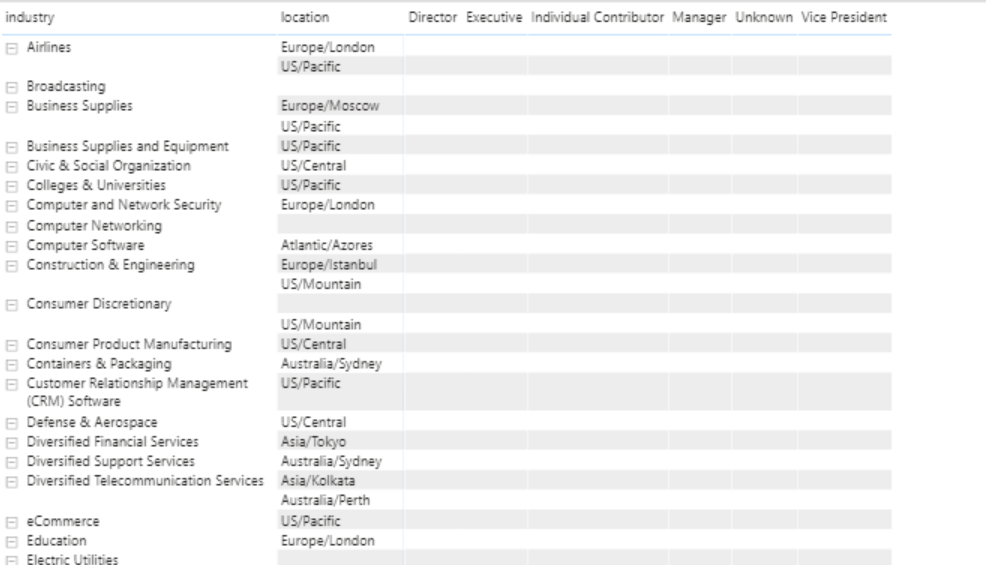

In [74]:
from IPython.display import Image
Image(filename='testing.png')

### **After picking the best model and running against unlabelled data, output the results in a clean format and deliver to the seller so they know the optimal mixture of job senorities to contact during the engagement.

In [ ]:
conn.close()